# Resample the ESA-CCI land cover map for Europe

This notebook demonstrates the use of the xcube.core.resampling.resample_in_space function to reproject the ESA-CCI Land Cover Map of Europe for the year 2022. The entire process is performed lazily and thus can be easily scaled up. 

In [1]:
from xcube.core.store import new_data_store
from xcube.core.resampling import resample_in_space
from xcube.core.gridmapping import GridMapping
from datetime import datetime

We use the land cover map stored in the [DeepESDL](https://www.earthsystemdatalab.net/) public S3 bucket. 

In [2]:
store = new_data_store("s3", root="deep-esdl-public")
mlds_lc = store.open_data("LC-1x2025x2025-2.0.0.levels")
ds = mlds_lc.base_dataset
ds

<xarray.Dataset> Size: 3TB
Dimensions:              (time: 31, lat: 64800, lon: 129600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 518kB 90.0 90.0 89.99 ... -90.0 -90.0
  * lon                  (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time                 (time) datetime64[ns] 248B 1992-01-01 ... 2022-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    crs                  int32 4B ...
    current_pixel_state  (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lat_bounds           (lat, bounds) float64 1MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 2MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 521GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] 496B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

We select the year and the spatial extend. 

In [3]:
%%time
ds = ds.sel(time=slice(datetime(2018, 1, 1), datetime(2022, 1, 1)), lat=slice(85, 25), lon=slice(-20, 40))
ds

CPU times: user 11 ms, sys: 2.07 ms, total: 13 ms
Wall time: 12.1 ms


<xarray.Dataset> Size: 28GB
Dimensions:              (time: 5, lat: 21600, lon: 21600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 173kB 85.0 85.0 84.99 ... 25.01 25.0 25.0
  * lon                  (lon) float64 173kB -20.0 -20.0 -19.99 ... 40.0 40.0
  * time                 (time) datetime64[ns] 40B 2018-01-01 ... 2022-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 2GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    crs                  int32 4B ...
    current_pixel_state  (time, lat, lon) float32 9GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    lat_bounds           (lat, bounds) float64 346kB dask.array<chunksize=(225, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 2GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 346kB dask.array<chunksize=(1125, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 5GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 9GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] 80B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

CPU times: user 1.87 s, sys: 425 ms, total: 2.3 s
Wall time: 8.03 s


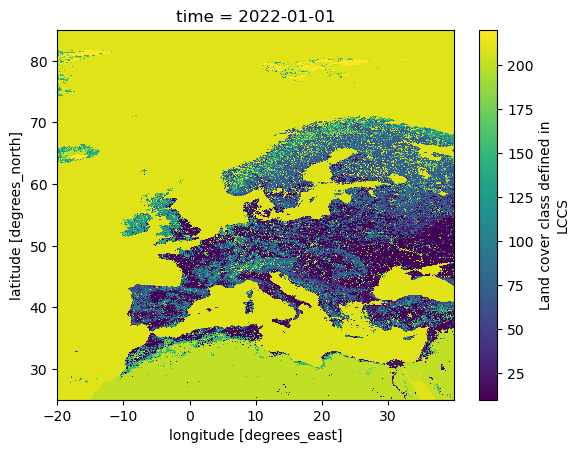

/home/konstantin/micromamba/envs/xcube-stac/lib/python3.12/site-packages/numpy/_core/numeric.py:362: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [4]:
%%time
ds.lccs_class.isel(time=-1)[::10, ::10].plot()

We first need to generate a grid mapping in the desired CRS, which will be subseqeuntly used for the reprojection in the following cell. 

In [5]:
%%time
source_gm = GridMapping.from_dataset(ds, tile_size=1024)
temp_target_gm = source_gm.transform("EPSG:3035", xy_res=300)
target_gm = temp_target_gm.to_regular()
target_gm

CPU times: user 841 ms, sys: 50.8 ms, total: 891 ms
Wall time: 857 ms


class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:3035
* xy_res: (300, 300)
* xy_bbox: (1287704, 239552, 7354604, 6907052)
* ij_bbox: (0, 0, 20223, 22225)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('x', 'y')
* size: (20223, 22225)
* tile_size: (1024, 1024)

In [6]:
%%time
ds_reproject = resample_in_space(
    ds,
    source_gm=source_gm,
    target_gm=target_gm,
    rectify_kwargs=dict(compute_subset=False),
)
ds_reproject

CPU times: user 27min 14s, sys: 36.2 s, total: 27min 50s
Wall time: 2min 16s


<xarray.Dataset> Size: 27GB
Dimensions:              (time: 5, y: 22225, x: 20223, bnds: 2)
Coordinates:
  * time                 (time) datetime64[ns] 40B 2018-01-01 ... 2022-01-01
  * y                    (y) float64 178kB 6.907e+06 6.907e+06 ... 2.397e+05
  * x                    (x) float64 162kB 1.288e+06 1.288e+06 ... 7.354e+06
    x_bnds               (x, bnds) float64 324kB 1.288e+06 ... 7.355e+06
    y_bnds               (y, bnds) float64 356kB 6.907e+06 ... 2.396e+05
Dimensions without coordinates: bnds
Data variables:
    change_count         (time, y, x) uint8 2GB dask.array<chunksize=(5, 1024, 1024), meta=np.ndarray>
    current_pixel_state  (time, y, x) float32 9GB dask.array<chunksize=(5, 1024, 1024), meta=np.ndarray>
    lccs_class           (time, y, x) uint8 2GB dask.array<chunksize=(5, 1024, 1024), meta=np.ndarray>
    observation_count    (time, y, x) uint16 4GB dask.array<chunksize=(5, 1024, 1024), meta=np.ndarray>
    processed_flag       (time, y, x) float32 9GB dask.array<chunksize=(5, 1024, 1024), meta=np.ndarray>
    crs                  int64 8B 0
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

CPU times: user 12min 23s, sys: 36.5 s, total: 12min 59s
Wall time: 1min 40s


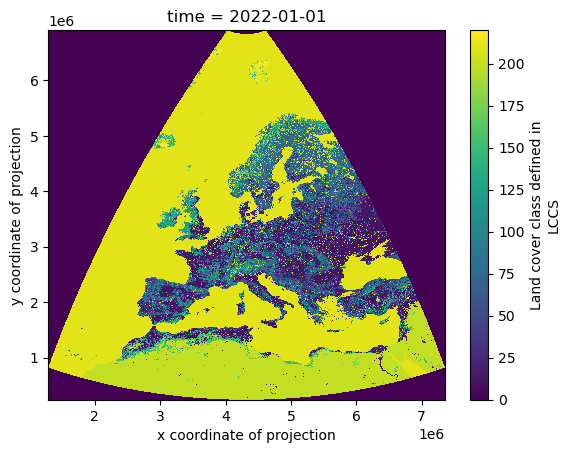

In [7]:
%%time
ds_reproject.lccs_class.isel(time=-1)[ ::10, ::10].plot()